In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
import os
import datetime
import sklearn
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.core.display import display, HTML

from io import StringIO
from scipy.optimize import curve_fit

In [2]:
#Settings
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style="darkgrid")
random_seed = 42
#chd = os.chdir('C:/Users/maga0002/OneDrive - HZ University of Applied Sciences/Master/Courses/DMT/Assignment 1/')
display(HTML("<style>.container { width:100% !important; }</style>"))
#CURR_DIR = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#df = pd.read_csv("E:/users/KMN14/Personal/DMT/dataset_mood_smartphone.csv", usecols=['id', 'time','variable','value'])
data = pd.read_csv("C:/Users/maga0002/Documents/GitHub/DMT-Group71/extrapolated_missing_values_imputation.csv")
data.head()


,id,period,time,value,mood,activity,arousal,valence,screen,call,sms,#appcat,appCat_duration
0,AS14.01,2014-02-12 till 2014-02-17,2014-02-17,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-13 till 2014-02-18,2014-02-18,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,AS14.01,2014-02-14 till 2014-02-19,2014-02-19,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
3,AS14.01,2014-02-15 till 2014-02-20,2014-02-20,1.0,NaN,NaN,NaN,NaN,NaN,10.0,2.0,NaN,NaN
4,AS14.01,2014-02-16 till 2014-02-21,2014-02-21,1.0,NaN,NaN,NaN,NaN,NaN,10.0,5.0,NaN,NaN


In [4]:
df = data

In [5]:
data.describe()

,value,mood,activity,arousal,valence,screen,call,sms,#appcat,appCat_duration
count,1973.000000,1269.000000,1187.000000,1278.000000,1278.000000,1223.000000,1705.000000,1311.000000,1223.000000,1223.000000
mean,0.676194,6.984555,0.121346,-0.099070,0.689858,84.853131,8.764809,3.787185,17.338512,37.236748
std,3.493111,0.761877,0.084262,0.516011,0.340949,54.833111,7.779483,3.843268,5.533106,27.128329
min,-2.000000,0.000000,0.000000,-2.000000,-1.000000,6.540000,1.000000,0.000000,1.000000,-64.135013
25%,0.000000,6.600000,0.068933,-0.416667,0.466667,50.589716,3.000000,1.000000,14.000000,24.328789
50%,0.083333,7.000000,0.100487,-0.066667,0.733333,71.694017,6.000000,2.000000,18.000000,31.062157
75%,1.000000,7.500000,0.146557,0.250000,0.933333,99.205449,12.000000,5.000000,21.000000,41.545489
max,76.427000,9.333333,0.500000,1.333333,2.000000,591.697000,56.000000,30.000000,32.000000,342.102154


In [6]:
df.columns

Index(['id', 'period', 'time', 'value', 'mood', 'activity', 'arousal', 'valence', 'screen', 'call', 'sms', '#appcat', 'appCat_duration'], dtype='object')

In [7]:
userids = list(df.id.unique())

In [8]:
scope = ['AS14.01', 'AS14.03']   # used person id's in the research
#scope = userids

In [9]:
scope

['AS14.01', 'AS14.03']

In [10]:
# Checking % of filled values within columns
variables = df.columns
count = []

for variable in variables:
    length = df[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(df), 2)

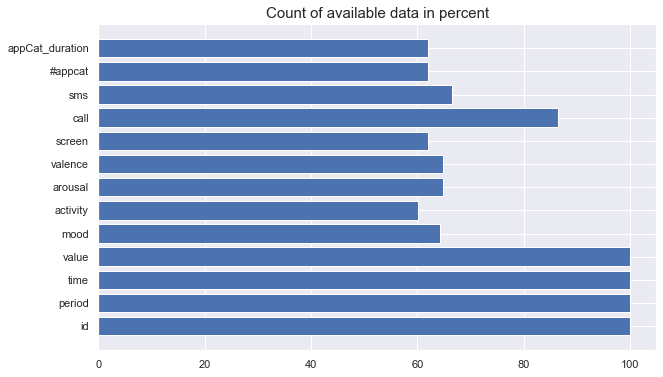

In [11]:
#Plot number of available data per variable
plt.figure(figsize=(10,6))
plt.barh(variables, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

In [12]:
nan_cols = [i for i in df.columns if df[i].isnull().any()]
nan_cols

['mood',
 'activity',
 'arousal',
 'valence',
 'screen',
 'call',
 'sms',
 '#appcat',
 'appCat_duration']

In [13]:
# extropolate - linear
def func(x, a, b, c, d):
    return a + b  + c * x + d

In [14]:
# # extrapolate - polynomial
# # define the true objective function
# def func(x, a, b, c):
#     return a * x + b * x**2 + c

In [15]:
# # extrapolate - polynomial 2nd degreeg
# # define the true objective function
# def func(x, a, b, c, d, e, f):
#     return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

In [16]:
# from numpy import sin
# def func(x, a, b, c, d):
#     return a * sin(b - x) + c * x**2 + d

In [17]:
guess = (0.5, 0.5, 0.5, 0.5)

In [18]:
# Create copy of data to remove NaNs for curve fitting
fit_df = df.dropna()
# Place to store function parameters for each column
col_params = {}

In [19]:
# Reg = used person id (just pointing 1 as a starter for later function)
reg='AS14.01'

In [20]:
# 
reg_fit_df = fit_df[fit_df['id']==reg]
#reg_fit_df

In [21]:
#reg_fit_df.info()

In [22]:
# Curve fit each column
for reg in scope: 
    reg_fit_df = fit_df[fit_df['id']==reg]
    for col in nan_cols:  
        # Get x & y
        x = reg_fit_df.index.astype(float).values
        y = reg_fit_df[col].values
        # Curve fit column and get curve parameters
        params = curve_fit(func, x, y, guess)
        # Store optimized parameters
        col_params[reg+col] = params[0]


C:\Users\maga0002\Anaconda3\envs\aml\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [23]:
# # Extrapolate each column
for reg in scope:
    for col in nan_cols:
        # Get the index values for NaNs in the column
        x = df[df['id']==reg][pd.isnull(df[col])].index.astype(float).values       
        # Extrapolate those points with the fitted function
        df[col][x] = func(x, *col_params[reg + col])
        
# Display result
print (df)
print ('Data was extrapolated with these column functions:')


           id                      period        time     value      mood  activity   arousal   valence      screen      call       sms    #appcat  appCat_duration
0     AS14.01  2014-02-12 till 2014-02-17  2014-02-17  1.000000  5.898824  0.144103  0.525906  0.116736   91.687242  11.79051 -1.560072  24.994322        43.067709
1     AS14.01  2014-02-13 till 2014-02-18  2014-02-18  1.000000  5.923830  0.143159  0.512041  0.128878   92.098470   2.00000 -1.484808  24.956690        42.951702
2     AS14.01  2014-02-14 till 2014-02-19  2014-02-19  1.000000  5.948836  0.142215  0.498177  0.141020   92.509697   3.00000 -1.409544  24.919058        42.835695
3     AS14.01  2014-02-15 till 2014-02-20  2014-02-20  1.000000  5.973841  0.141271  0.484312  0.153161   92.920924  10.00000  2.000000  24.881426        42.719688
4     AS14.01  2014-02-16 till 2014-02-21  2014-02-21  1.000000  5.998847  0.140327  0.470448  0.165303   93.332152  10.00000  5.000000  24.843793        42.603680
...       ...   

<ipython-input-23-481953eec44f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = df[df['id']==reg][pd.isnull(df[col])].index.astype(float).values
<ipython-input-23-481953eec44f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][x] = func(x, *col_params[reg + col])
C:\Users\maga0002\Anaconda3\envs\aml\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:
df

,id,period,time,value,mood,activity,arousal,valence,screen,call,sms,#appcat,appCat_duration
0,AS14.01,2014-02-12 till 2014-02-17,2014-02-17,1.000000,5.898824,0.144103,0.525906,0.116736,91.687242,11.79051,-1.560072,24.994322,43.067709
1,AS14.01,2014-02-13 till 2014-02-18,2014-02-18,1.000000,5.923830,0.143159,0.512041,0.128878,92.098470,2.00000,-1.484808,24.956690,42.951702
2,AS14.01,2014-02-14 till 2014-02-19,2014-02-19,1.000000,5.948836,0.142215,0.498177,0.141020,92.509697,3.00000,-1.409544,24.919058,42.835695
3,AS14.01,2014-02-15 till 2014-02-20,2014-02-20,1.000000,5.973841,0.141271,0.484312,0.153161,92.920924,10.00000,2.000000,24.881426,42.719688
4,AS14.01,2014-02-16 till 2014-02-21,2014-02-21,1.000000,5.998847,0.140327,0.470448,0.165303,93.332152,10.00000,5.000000,24.843793,42.603680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-22 till 2014-05-27,2014-05-27,0.000000,6.200000,0.096986,-0.633333,0.194444,179.864417,12.00000,4.000000,17.000000,36.507638
1969,AS14.33,2014-05-23 till 2014-05-28,2014-05-28,0.000000,8.200000,0.096459,-0.583333,0.244444,165.196909,13.00000,6.000000,18.000000,30.341190
1970,AS14.33,2014-05-24 till 2014-05-29,2014-05-29,0.000000,7.000000,0.077069,-0.333333,0.533333,175.888414,21.00000,6.000000,19.000000,30.853924
1971,AS14.33,2014-05-25 till 2014-05-30,2014-05-30,0.086207,6.800000,0.095120,-0.644444,0.866667,115.414489,16.00000,4.000000,20.000000,29.665334


In [25]:
df[nan_cols]

,mood,activity,arousal,valence,screen,call,sms,#appcat,appCat_duration
0,5.898824,0.144103,0.525906,0.116736,91.687242,11.79051,-1.560072,24.994322,43.067709
1,5.923830,0.143159,0.512041,0.128878,92.098470,2.00000,-1.484808,24.956690,42.951702
2,5.948836,0.142215,0.498177,0.141020,92.509697,3.00000,-1.409544,24.919058,42.835695
3,5.973841,0.141271,0.484312,0.153161,92.920924,10.00000,2.000000,24.881426,42.719688
4,5.998847,0.140327,0.470448,0.165303,93.332152,10.00000,5.000000,24.843793,42.603680
...,...,...,...,...,...,...,...,...,...
1968,6.200000,0.096986,-0.633333,0.194444,179.864417,12.00000,4.000000,17.000000,36.507638
1969,8.200000,0.096459,-0.583333,0.244444,165.196909,13.00000,6.000000,18.000000,30.341190
1970,7.000000,0.077069,-0.333333,0.533333,175.888414,21.00000,6.000000,19.000000,30.853924
1971,6.800000,0.095120,-0.644444,0.866667,115.414489,16.00000,4.000000,20.000000,29.665334


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1973 non-null   object 
 1   period           1973 non-null   object 
 2   time             1973 non-null   object 
 3   value            1973 non-null   float64
 4   mood             1324 non-null   float64
 5   activity         1243 non-null   float64
 6   arousal          1331 non-null   float64
 7   valence          1331 non-null   float64
 8   screen           1278 non-null   float64
 9   call             1714 non-null   float64
 10  sms              1346 non-null   float64
 11  #appcat          1278 non-null   float64
 12  appCat_duration  1278 non-null   float64
dtypes: float64(10), object(3)
memory usage: 200.5+ KB


In [27]:
df.describe()

,value,mood,activity,arousal,valence,screen,call,sms,#appcat,appCat_duration
count,1973.000000,1324.000000,1243.000000,1331.000000,1331.000000,1278.000000,1714.000000,1346.000000,1278.000000,1278.000000
mean,0.676194,6.995863,0.121567,-0.071782,0.693811,83.799173,8.762879,3.721884,17.546854,37.245257
std,3.493111,0.771981,0.082362,0.525886,0.347467,54.351706,7.760028,3.821195,5.520563,26.553781
min,-2.000000,0.000000,0.000000,-2.000000,-1.000000,6.540000,1.000000,-1.560072,1.000000,-64.135013
25%,0.000000,6.600000,0.070760,-0.400000,0.466667,49.569695,3.000000,1.000000,14.000000,24.673086
50%,0.083333,7.000000,0.102814,-0.066667,0.733333,71.628151,6.000000,2.000000,18.000000,31.667018
75%,1.000000,7.500000,0.142601,0.289549,0.966667,98.653232,12.000000,5.000000,21.000000,41.550097
max,76.427000,9.333333,0.500000,1.333333,2.000000,591.697000,56.000000,30.000000,32.000000,342.102154


mood


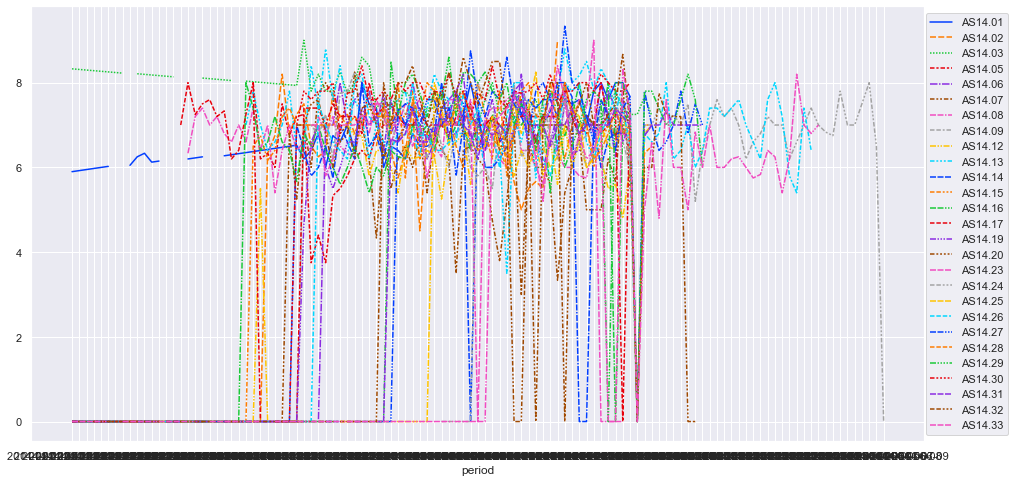

activity


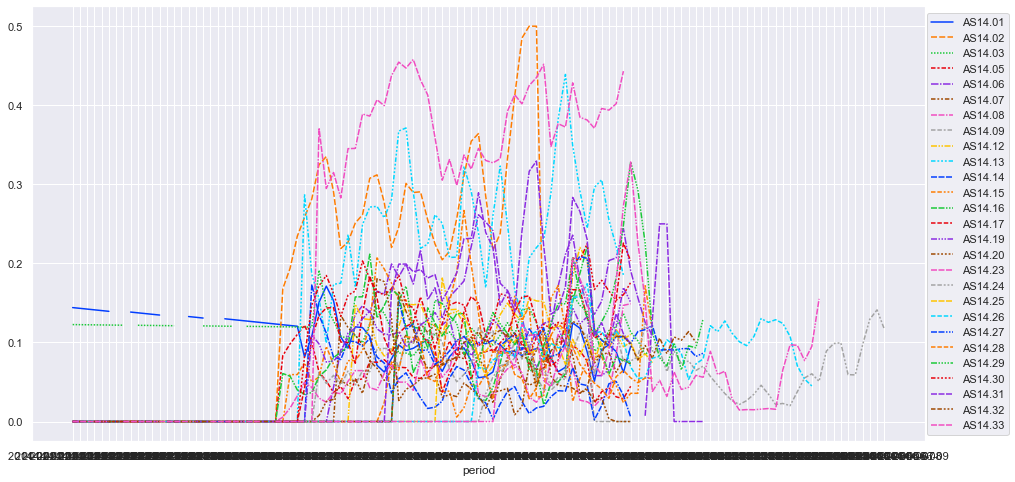

arousal


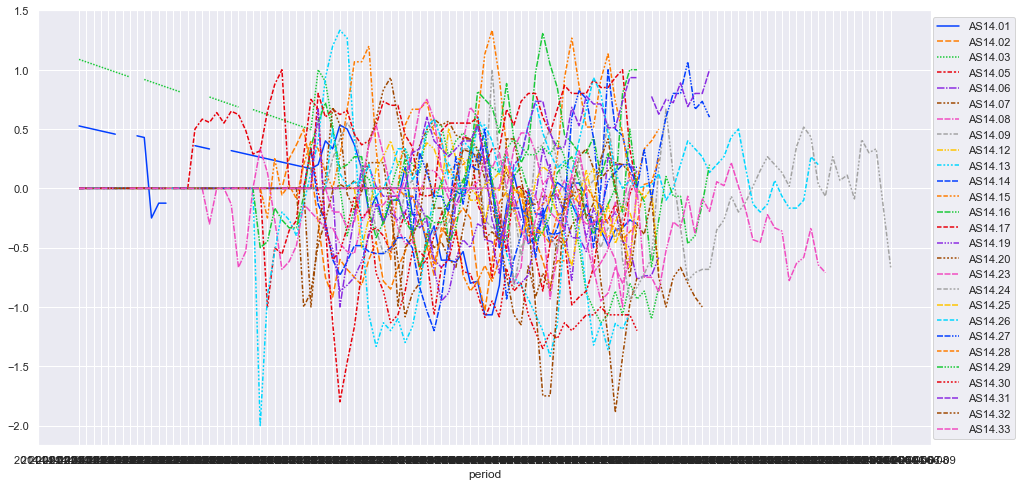

valence


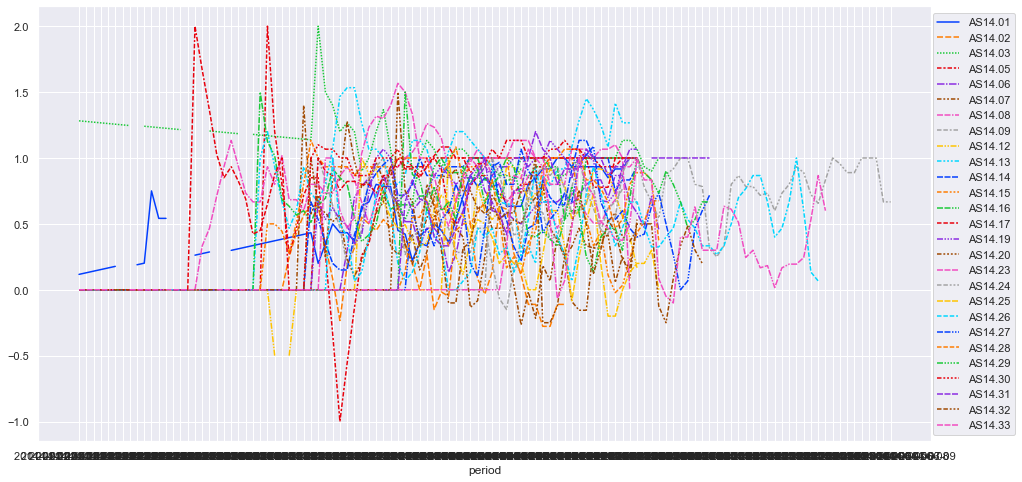

screen


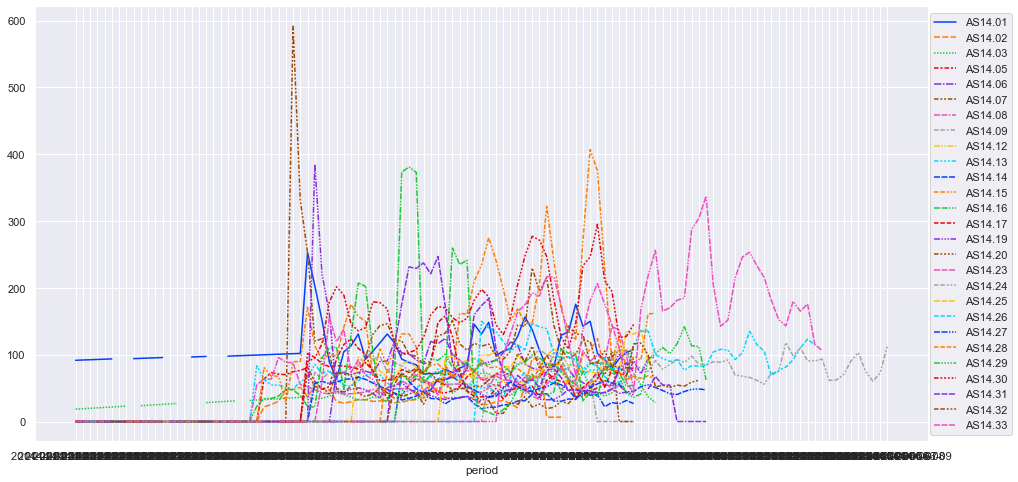

call


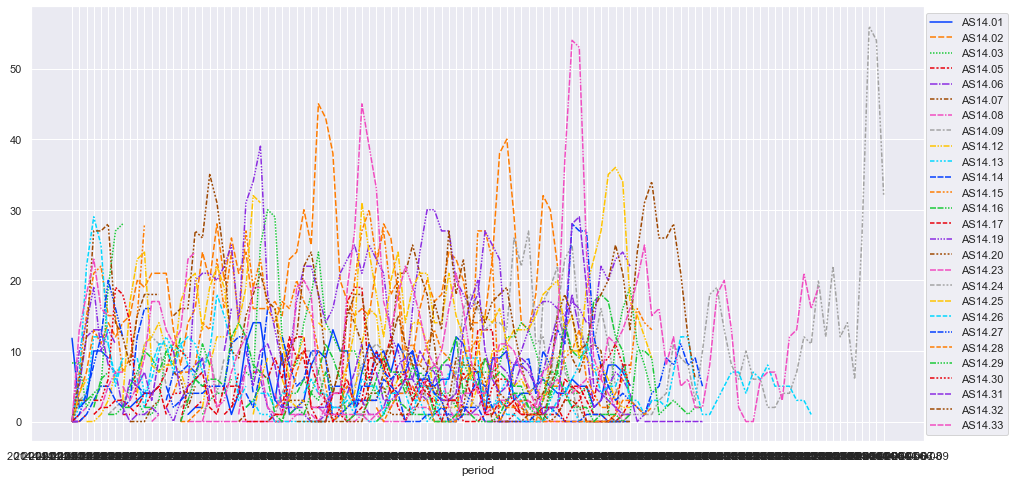

sms


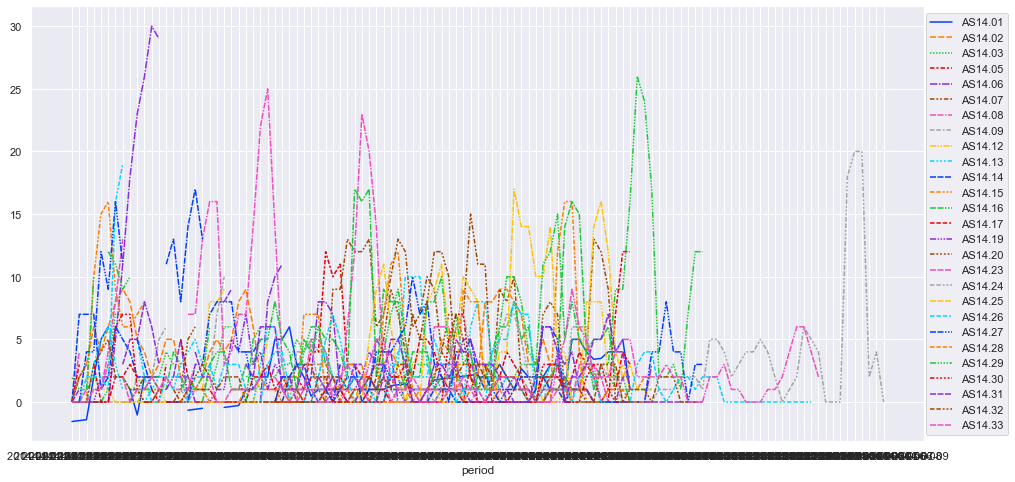

#appcat


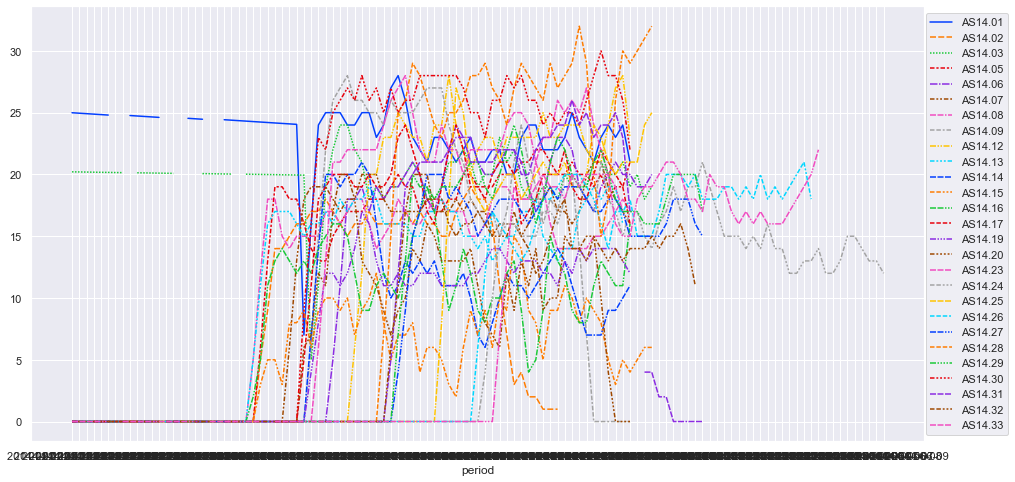

appCat_duration


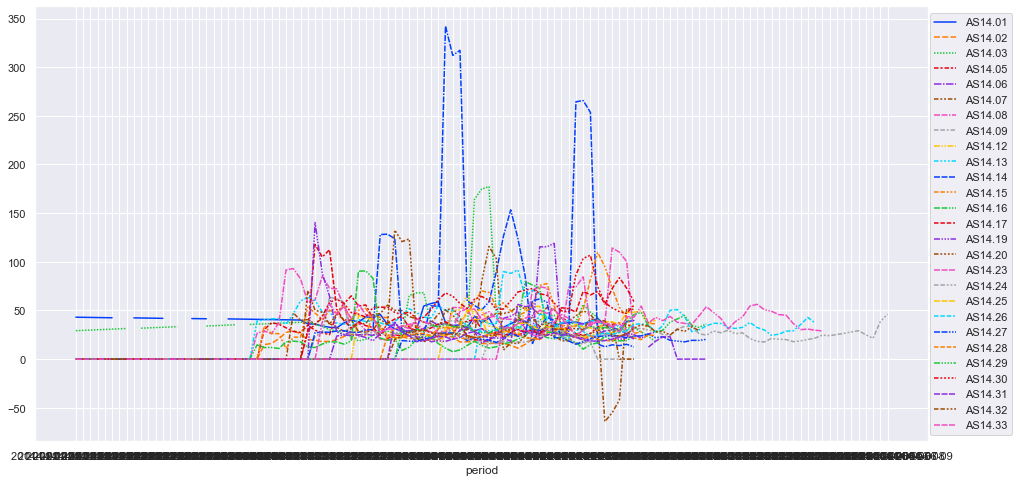

In [28]:
for i in nan_cols:
    plotdf = df.pivot_table(index='period',columns='id',values=i,aggfunc='sum')
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(data=plotdf, ax=ax, palette='bright') 

    # Put a legend to the right side
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)
    
    print(i)

    plt.show()

In [30]:
#final
df.to_csv("C:/Users/maga0002/Documents/GitHub/DMT-Group71/improved_mse_results/extraploted_missing_values.csv",index=False)